In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Loading Dataset

# 1. Training Data
dt = pd.read_csv(r"C:\Users\haider computer s\Fiver\SentimentAnalysis-LargeMovieReview-main\aclImdb\CSV\Train\merged_train.csv")
# 2. Testing Data
t_dt = pd.read_csv(r"C:\Users\haider computer s\Fiver\SentimentAnalysis-LargeMovieReview-main\aclImdb\CSV\Test\merged_test.csv")

In [3]:
import string
# removing the html tags
def clean_html(text):
    clean=re.compile('<.*?>')
    cleantext=re.sub(clean,'',text)
    return cleantext
    
# first round of cleaning
def clean_text1(text):
    text=text.lower()
    text=re.sub('\[.*?\]','',text)
    text=re.sub('[%s]'%re.escape(string.punctuation),'',text)
    text=re.sub('\w*\d\w*','',text)
    return text

# second round of cleaning
def clean_text2(text):
    text=re.sub('[''"",,,]','',text)
    text=re.sub('\n','',text)
    return text
    
cleaned_html=lambda x:clean_html(x)
cleaned1=lambda x:clean_text1(x)
cleaned2=lambda x:clean_text2(x)

dt['comment']=pd.DataFrame(dt.comment.apply(cleaned_html))
dt['comment']=pd.DataFrame(dt.comment.apply(cleaned1))
dt['comment']=pd.DataFrame(dt.comment.apply(cleaned2))

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
max_features=5000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(dt['comment'].values)
X = tokenizer.texts_to_sequences(dt['comment'].values)
X = pad_sequences(X,maxlen=600)

In [5]:
import keras.backend as K
import tensorflow as tf
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
def conditional_average_metric(y_true, y_pred):
    spec = specificity(y_true, y_pred)
    sens = sensitivity(y_true, y_pred)

    minimum = K.minimum(spec, sens)
    condition = K.less(minimum, 0.5)

    multiplier = 0.001
    # This is the constant used to substantially lower
    # the final value of the metric and it can be set to any value
    # but it is recommended to be much lower than 0.5

    result_greater = 0.5 * (spec + sens)
    result_lower = multiplier * (spec + sens)
    result = K.switch(condition, result_lower, result_greater)

    return result
def sensitivity(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def F1_Score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
metrics=[tf.keras.metrics.AUC(num_thresholds=200,curve='ROC',summation_method='interpolation',name=None,dtype=None,thresholds=None,multi_label=False,num_labels=None,label_weights=None,from_logits=False),
                         tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy',
                   specificity,conditional_average_metric ,sensitivity,F1_Score]

In [6]:
# EarlyStopping
from keras.callbacks import ModelCheckpoint,EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

#ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='SimpleRNN.h5',
                                  save_best_only=True,
                                  verbose=1)

In [7]:
#Create Model
import tensorflow as tf

embed_dim = 128
simplernn_dim = 128

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(10000, embed_dim,input_length = X.shape[1]))
model.add(tf.keras.layers.SpatialDropout1D(0.5))
model.add(tf.keras.layers.SimpleRNN(simplernn_dim))

model.add(tf.keras.layers.Dense(2,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = metrics)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 128)          1280000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 600, 128)         0         
 ropout1D)                                                       
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 1,313,154
Trainable params: 1,313,154
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
from sklearn.model_selection import train_test_split as tts
Y=pd.get_dummies(dt['sentiment']).values
X_train, X_test, Y_train, Y_test = tts(X,Y, test_size = 0.2, random_state = 42)

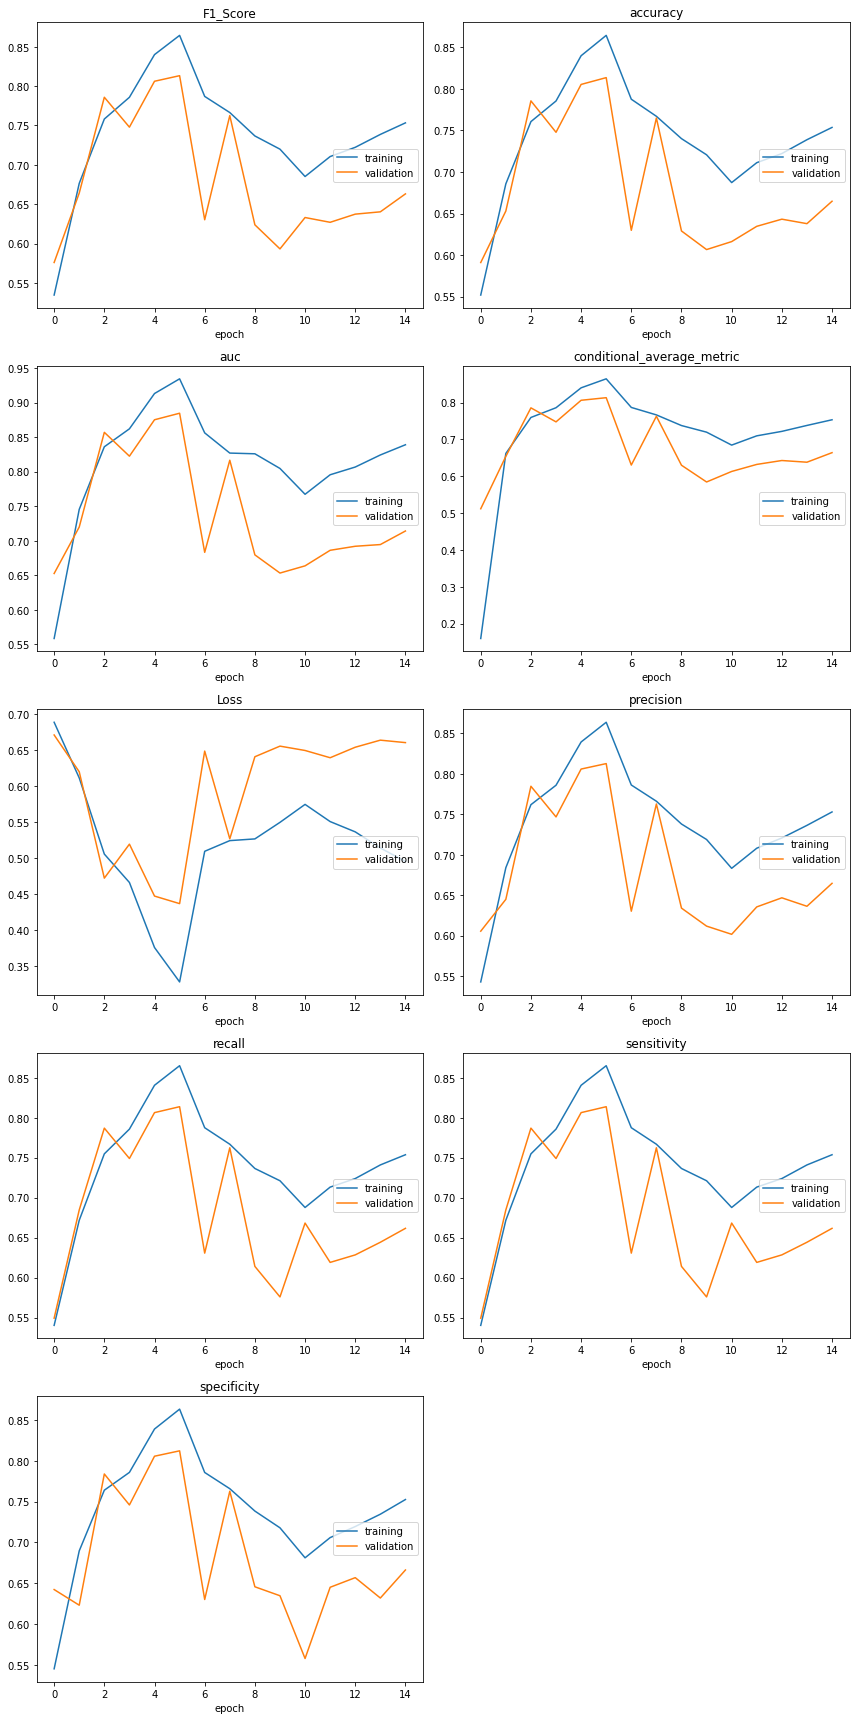

F1_Score
	training         	 (min:    0.535, max:    0.864, cur:    0.753)
	validation       	 (min:    0.576, max:    0.813, cur:    0.663)
accuracy
	training         	 (min:    0.552, max:    0.864, cur:    0.754)
	validation       	 (min:    0.591, max:    0.814, cur:    0.665)
auc
	training         	 (min:    0.559, max:    0.934, cur:    0.839)
	validation       	 (min:    0.653, max:    0.885, cur:    0.714)
conditional_average_metric
	training         	 (min:    0.160, max:    0.864, cur:    0.753)
	validation       	 (min:    0.512, max:    0.813, cur:    0.664)
Loss
	training         	 (min:    0.328, max:    0.688, cur:    0.495)
	validation       	 (min:    0.437, max:    0.671, cur:    0.660)
precision
	training         	 (min:    0.543, max:    0.864, cur:    0.753)
	validation       	 (min:    0.602, max:    0.813, cur:    0.665)
recall
	training         	 (min:    0.540, max:    0.865, cur:    0.754)
	validation       	 (min:    0.549, max:    0.814, cur:    0.662)
sensi

In [9]:
model.fit(X_train, Y_train, epochs = 15, batch_size=200, validation_data=(X_test, Y_test),verbose = 1,callbacks=[early_stop,plot_loss_1,tl_checkpoint_1])